In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset_path = '/content/drive/My Drive/Computer Vision Project work/FracAtlas/images/Fractured'

fractured_labels = []
fractured_images = []
sizeTup = (244,244)

for image_file in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_file)

    #print(image_file)

    fractured_labels.append(1)

    image = cv2.imread(image_path)
    if image is not None:
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(gray_image, sizeTup)
      fractured_images.append(np.array(resized_img))

fractured_images_array = np.array(fractured_images)

label:  1


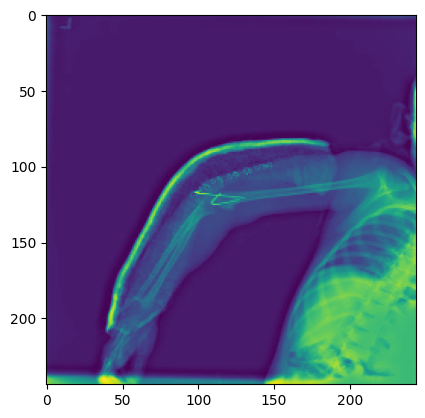

In [ ]:
fractured_images_array[0]
print("label: ",fractured_labels[0])

fractured_image = fractured_images_array[0]
plt.imshow(fractured_image)

In [ ]:
dataset_path = '/content/drive/My Drive/Computer Vision Project work/FracAtlas/images/Non_fractured'

non_fractured_images = []
non_fractured_labels = []
sizeTup = (244,244)

for image_file in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_file)

    #print(image_file)

    non_fractured_labels.append(0)

    image = cv2.imread(image_path)
    if image is not None:
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(gray_image, sizeTup)
      non_fractured_images.append(np.array(resized_img))

non_fractured_images_array = np.array(non_fractured_images)

label:  0
object dimensions:  (244, 244)


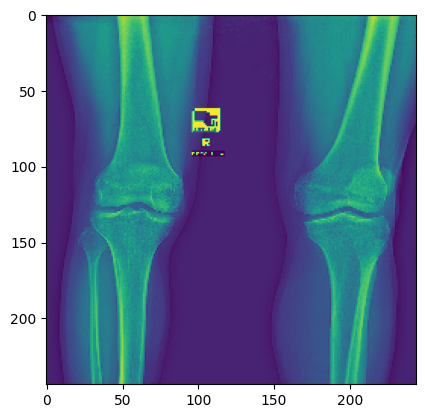

In [ ]:
non_fractured_images_array[0]
print("label: ",non_fractured_labels[0])

non_fractured_image = non_fractured_images_array[0]
print("object dimensions: ",non_fractured_images_array[0].shape)
plt.imshow(non_fractured_image)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
merged_images_array = np.concatenate((fractured_images_array, non_fractured_images_array), axis=0)

fractured_labels = np.ones(fractured_images_array.shape[0], dtype=int)
non_fractured_labels = np.zeros(non_fractured_images_array.shape[0], dtype=int)

merged_labels_array = np.concatenate((fractured_labels, non_fractured_labels), axis=0)

SEED = 1234
np.random.seed(SEED)

indices = np.arange(merged_images_array.shape[0])
np.random.shuffle(indices)

shuffled_images_array = merged_images_array[indices]
shuffled_labels_array = merged_labels_array[indices]

In [ ]:
means = shuffled_images_array.mean(axis=(0, 1, 2)) / 255
stds = shuffled_images_array.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: 0.20183007971091985
Calculated stds: 0.1904141953101284


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [ ]:
train_size = int(0.5 * len(shuffled_images_array))
val_size = int(0.05 * len(shuffled_images_array))
test_size = len(shuffled_images_array) - train_size - val_size

In [ ]:
train_indices = indices[:train_size]

train_transformed_images = []

X_train = shuffled_images_array[train_indices]
y_train = shuffled_labels_array[train_indices]

for img in X_train:
    img = Image.fromarray(img.astype('uint8'))

    transformed_img = train_transforms(img)
    train_transformed_images.append(transformed_img)

train_batch_tensor = torch.stack(train_transformed_images)

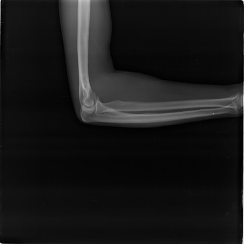

0


In [ ]:
cv2_imshow(X_train[77])
print(y_train[77])

In [ ]:
val_indices = indices[train_size:train_size + val_size]

validation_transformed_images = []

X_val = shuffled_images_array[val_indices]
y_val = shuffled_labels_array[val_indices]

for img in X_val:
    img = Image.fromarray(img.astype('uint8'))

    transformed_img = test_transforms(img)
    validation_transformed_images.append(transformed_img)

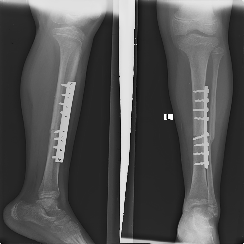

1


In [ ]:
cv2_imshow(X_val[28])
print(y_val[28])

In [ ]:
test_indices = indices[train_size + val_size:]

test_transformed_images = []

X_test = shuffled_images_array[test_indices]
y_test = shuffled_labels_array[test_indices]

for img in X_test:
    img = Image.fromarray(img.astype('uint8'))

    transformed_img = test_transforms(img)
    test_transformed_images.append(transformed_img)

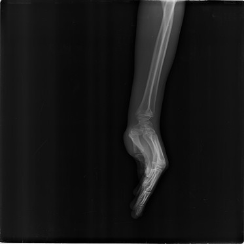

0


In [ ]:
cv2_imshow(X_test[99])
print(y_test[99])

In [ ]:
print(f'Number of training examples: {len(X_train)}')
print(f'Number of validation examples: {len(X_val)}')
print(f'Number of testing examples: {len(X_test)}')

Number of training examples: 2041
Number of validation examples: 204
Number of testing examples: 1838


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#fit encoder to labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

#convert the lists of transformed images to sets
X_train_tensor = torch.stack(train_transformed_images)
X_valid_tensor = torch.stack(validation_transformed_images)
X_test_tensor = torch.stack(test_transformed_images)

#convert labels to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_valid_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 512

#create DataLoader objects for train, validation, and test sets
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

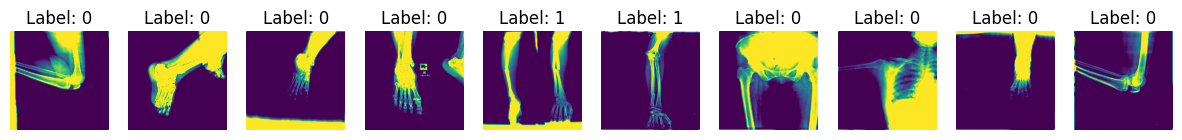

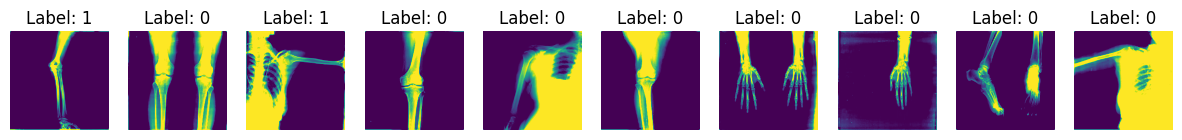

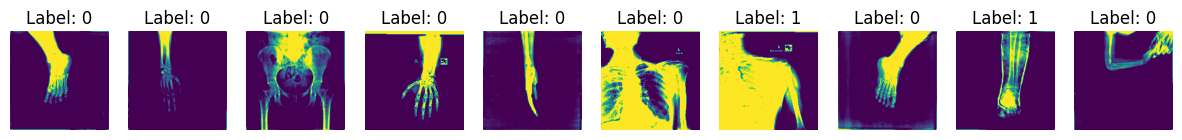

In [ ]:
def display_images(images,labels=None,num_images = 5):
    if isinstance(images, torch.Tensor):
        images = images.numpy()

    images = np.clip(images, 0, 1)

    images = np.transpose(images, (0, 2, 3, 1))

    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        if labels is not None:
            plt.title(f'Label: {labels[i]}')
    plt.show()

def display_train_images(train_loader, num_images=5):
    for images, labels in train_loader:
        display_images(images, labels, num_images)
        break

def display_valid_images(valid_loader, num_images=5):
    for images, labels in valid_loader:
        display_images(images, labels, num_images)
        break

def display_test_images(test_loader, num_images=5):
    for images, labels in test_loader:
        display_images(images, labels, num_images)
        break

display_train_images(train_loader, num_images=10)
display_valid_images(valid_loader, num_images=10)
display_test_images(test_loader, num_images=10)

In [ ]:
import pickle

def save_data(filename, data):
    file_path = f'/content/drive/My Drive/Computer Vision Project work/{filename}'
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

data_to_save = {
    'train_loader': train_loader,
    'valid_loader': valid_loader,
    'test_loader': test_loader
}

save_data('loaders.pkl', data_to_save)